In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.linalg as la


import quandl
quandl.read_key()

In [2]:
ticker_list = list(set([x[0] for x in quandl.get_table('SHARADAR/SEP')[['ticker']].values.tolist()]) &
                  set([x[0] for x in quandl.get_table('SHARADAR/DAILY')[['ticker']].values.tolist()]))
print(len(ticker_list))
print(ticker_list)

28
['GS', 'CVX', 'XOM', 'WMT', 'VZ', 'AAPL', 'GE', 'MSFT', 'AXP', 'HD', 'PG', 'CSCO', 'KO', 'CAT', 'PFE', 'DD', 'TSLA', 'JNJ', 'JPM', 'TRV', 'UNH', 'MCD', 'MMM', 'MRK', 'IBM', 'NKE', 'INTC', 'BA']


In [110]:
daily = quandl.get_table('SHARADAR/DAILY', ticker=ticker_list)
SEP = quandl.get_table('SHARADAR/SEP', ticker=ticker_list)
date_list = sorted(list(set(SEP['date'].tolist())))

def yesterday(today):
    return date_list[date_list.index(today)-1]

## GMV portfolio

In [118]:
size = 10
window = 30
day = pd.Timedelta(days=1)

start_date = date_list[window]
end_date = date_list[-1]

now_date = start_date

asset = 1
asset_list = [1]

while(now_date <= end_date):
    print(now_date)
    if now_date in date_list:
        if now_date > start_date:
            ret = 0
            for idx in range(size):
                ret += long_weight[idx]*(SEP[(SEP.ticker == long_list[idx]) & (SEP.date == now_date)].close.values[0]
                                  / SEP[(SEP.ticker == long_list[idx]) & (SEP.date == yesterday(now_date))].close.values[0])
            asset = ret*asset
            asset_list.append(asset)
            print(ret, asset)
        
        long_list = daily.loc[daily['date']==now_date].sort_values('marketcap')[-size:]['ticker'].tolist()
        corr_df = SEP[(SEP.ticker == long_list[0]) & (now_date - window*day <= SEP.date) & (SEP.date < now_date) ][['date']]
        for long in long_list:
            input_data = 100*(SEP[(SEP.ticker == long) & (now_date - window*day <= SEP.date) & (SEP.date < now_date) ].close.diff(periods=-1)
                          / SEP[(SEP.ticker == long) & (now_date - window*day <= SEP.date) & (SEP.date < now_date) ].close)
            corr_df[long] = input_data.tolist()

        eigsys = la.eig(corr_df.cov().to_numpy())
        for idx in range(len(eigsys[1])):
            eigsys[1][idx]= eigsys[1][idx]/(np.sum(eigsys[1][idx]))

        option = []
        for idx in range(len(eigsys[1])):
            option.append(eigsys[0][idx]*np.sum([a*a for a in eigsys[1][idx]]))

        opt_idx = np.argmin(option)
        long_weight = list(eigsys[1][opt_idx])
        
        
    now_date += day

2018-10-16 00:00:00
2018-10-17 00:00:00
1.0070025637661928 1.0070025637661928
2018-10-18 00:00:00
0.9980154005506177 1.005004067032616
2018-10-19 00:00:00
1.0061363852484975 1.0111711591642347
2018-10-20 00:00:00
2018-10-21 00:00:00
2018-10-22 00:00:00
0.9857437062828704 0.9967556061208991
2018-10-23 00:00:00
1.0002783225484821 0.9970330256814085
2018-10-24 00:00:00
0.9872824371954806 0.9843531955591251
2018-10-25 00:00:00
1.025946915408293 1.0098941246561806
2018-10-26 00:00:00
0.987310540809886 0.9970791143750201
2018-10-27 00:00:00
2018-10-28 00:00:00
2018-10-29 00:00:00
1.0210250208981115 1.0180427235918255
2018-10-30 00:00:00
1.0159505123332542 1.0342810266102564
2018-10-31 00:00:00
1.0184505247369235 1.0533640542766596
2018-11-01 00:00:00
1.0064310281595459 1.0601382681719662
2018-11-02 00:00:00
0.9891566436333197 1.0486428111322224
2018-11-03 00:00:00
2018-11-04 00:00:00
2018-11-05 00:00:00
0.9984111167796988 1.046976640165525
2018-11-06 00:00:00
1.0027044654307762 1.04980815229

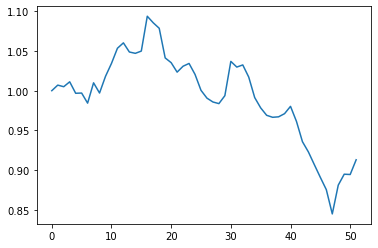

In [119]:
plt.plot(asset_list)

## Cap-weighted portfolio

In [128]:
size = 10
window = 30
day = pd.Timedelta(days=1)

start_date = date_list[window]
end_date = date_list[-1]

now_date = start_date

asset = 1
BM_asset_list = [1]

while(now_date <= end_date):
    print(now_date)
    if now_date in date_list:
        if now_date > start_date:
            ret = 0
            for idx in range(len(long_list)):
                ret += long_weight[idx]*(SEP[(SEP.ticker == long_list[idx]) & (SEP.date == now_date)].close.values[0]
                                  / SEP[(SEP.ticker == long_list[idx]) & (SEP.date == yesterday(now_date))].close.values[0])
            asset = ret*asset
            BM_asset_list.append(asset)
            print(ret, asset)
        
        long_list = daily.loc[daily['date']==now_date].sort_values('marketcap')[-size:]['ticker'].tolist()
        long_weight = []
        for long in long_list:
            weight = daily.loc[(daily.date == now_date) & (daily.ticker == long)].marketcap.values[0]
            long_weight.append(weight)
        long_weight /= np.sum(long_weight)
        
        
    now_date += day

2018-10-16 00:00:00
2018-10-17 00:00:00
1.0018285922302812 1.0018285922302812
2018-10-18 00:00:00
0.9887356034396484 0.9905435976819005
2018-10-19 00:00:00
1.0053456446636504 0.9958386917789618
2018-10-20 00:00:00
2018-10-21 00:00:00
2018-10-22 00:00:00
0.999763652880564 0.9956033281727369
2018-10-23 00:00:00
0.9987044274422467 0.9943134518223485
2018-10-24 00:00:00
0.970452528205537 0.9649340031497725
2018-10-25 00:00:00
1.0224077042732702 0.9865559589355754
2018-10-26 00:00:00
0.9863696851032406 0.9731088905520091
2018-10-27 00:00:00
2018-10-28 00:00:00
2018-10-29 00:00:00
0.9928632651174372 0.9661640703882746
2018-10-30 00:00:00
1.0104698276187423 0.9762796416566621
2018-10-31 00:00:00
1.0124976462807476 0.9884808392891821
2018-11-01 00:00:00
1.0042077950052635 0.9926401640275417
2018-11-02 00:00:00
0.9845206232687698 0.9772747129700092
2018-11-03 00:00:00
2018-11-04 00:00:00
2018-11-05 00:00:00
1.0002322238316086 0.9775016594483893
2018-11-06 00:00:00
1.0040364380230515 0.981447284

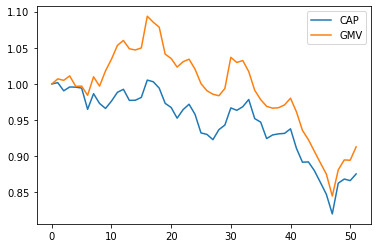

In [129]:
plt.plot(BM_asset_list)
plt.plot(asset_list)
plt.legend(['CAP','GMV'])

AttributeError: module 'numpy' has no attribute 'stdev'